# SFINCS model run and postprocessing
In this file the SFINCS model is run from script. This uses the files built in hel_model_build.ipynb.

In [1]:
import os
k=%pwd
root = os.path.join(k, "xan_catalog\\helensville_data")
print(root)

C:\Users\xfsmi\PycharmProjects\pythonProject\SFINCS\xan_catalog\helensville_data


# Run model

## 1. inspect and build files
Two files should be looked at: run.bat and sfincs_log.txt.
run.bat can be built in notepad or other text editor, and should be put in the same location as where all the other files were written.
In first instance the sfincs_log.txt should output an error message. This is because the SFINCS model hasn't been run yet


In [3]:
fn = "./xan_catalog/helensville_data/run.bat"
with open(fn, "r") as f:
    txt = f.read()
print(txt)


call "C:\Users\xfsmi\Documents\3Software\SFINCS_2022_release\SFINCS_v2.0.0_AlpeDHuez_release_exe\sfincs.exe">sfincs_log.txt



In [4]:
# fn = "./xan_catalog/helensville_data/sfincs_log.txt"
# with open(fn, "r") as f:
#     txt = f.read()
# print(txt)


## 2. Run model
First the model is run, after which the logs are opened to see what happened, and afterwards the result is checked

In [5]:
run_path = "./xan_catalog/helensville_data"

cur_dir = os.getcwd()

os.chdir(run_path)
os.system("run.bat")
os.chdir(cur_dir)


In [6]:
fn = "./xan_catalog/helensville_data/sfincs_log.txt"
with open(fn, "r") as f:
    txt = f.read()
print(txt)



 ----------- Welcome to SFINCS -----------

  @@@@@  @@@@@@@ @@ @@  @@   @@@@   @@@@@ 
 @@@ @@@ @@@@@@@ @@ @@@ @@ @@@@@@@ @@@ @@@
 @@@     @@      @@ @@@ @@ @@   @@ @@@    
  @@@@@  @@@@@@  @@ @@@@@@ @@       @@@@@ 
     @@@ @@      @@ @@ @@@ @@   @@     @@@
 @@@ @@@ @@      @@ @@  @@  @@@@@@ @@@ @@@
  @@@@@  @@      @@ @@   @   @@@@   @@@@@ 

 -----------------------------------------

 Build-Revision: $Rev: v2.0.0$
 Build-Date:     $Date: 2022-11-16

 Reading input file ...
 Info : Running SFINCS in regular mode ...
 Reading meteo data ...
 Reading FEWS compatible NetCDF type precipitation input ...
 Info : Preparing SFINCS grid on regular mesh ...
 Turning on process: Precipitation
 Turning on flag: meteo3d
 Reading sfincs.ind ...
 Reading sfincs.msk ...
 Number of active z points    :       315143
 Number of active u/v points  :       628785
 Reading sfincs.dep
 Reading sfincs.man
 Turning on process: Infiltration (via CN method - A)
 Reading sfincs.scs
 Reading water level bounda

Three new output files additional to model files, sfincs_log.txt and two .nc documents.

In [7]:
path = "./xan_catalog/helensville_data"

dir_list = os.listdir(path)

# prints all files
print(dir_list)


['elevtn4326.tif', 'figs', 'GCN250_ARCII', 'gis', 'global_land_cover', 'gswo', 'hydromt.log', 'merit_hydro', 'nzbathy_2016', 'obs_points', 'precip.nc', 'rainfall_era5', 'rivers_shapefile', 'run.bat', 'sfincs.bnd', 'sfincs.bzs', 'sfincs.dep', 'sfincs.ind', 'sfincs.inp', 'sfincs.man', 'sfincs.msk', 'sfincs.obs', 'sfincs.scs', 'sfincs_his.nc', 'sfincs_log.txt', 'sfincs_map.nc']


# Post processing

### 1. inspect files
in this step the .nc files are loaded and inspected. This inspection isn't necessary, but I did this because of the errors reading in the files. If no observation points used, there is no his file
The only weird thing I could find were extremely high values for the station_id values when the observation points were added.


In [8]:
# import dependencies
import xarray as xr
import matplotlib.pyplot as plt
from hydromt_sfincs import SfincsModel


In [10]:
his = xr.open_dataset("xan_catalog/helensville_data/sfincs_his.nc")
map = xr.open_dataset("xan_catalog/helensville_data/sfincs_map.nc")
# his.crs.attrs['EPSG']=32560
# his
# his.point_y.values

In [11]:
his.station_id.values

array([9.96921e+36, 9.96921e+36, 9.96921e+36], dtype=float32)

#### 1.1 from release manual report AlpeDHuez
Tip to check your model: specify netcdf output and load in the sfincs_map.nc file (e.g. Quickplot, Panoply, Matlab, Python) and have a look at the variables ‘zb’ and ‘msk’. Then you can see how SFINCS has interpreted the prodivided depfile and mskfile. Does map plots of these variables look weird? Probably something in your input file is not entirely correct!

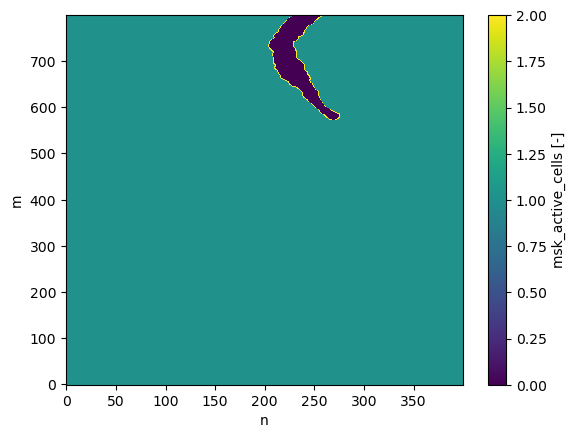

In [13]:
map = xr.open_dataset("xan_catalog/helensville_data/sfincs_map.nc")
map['msk'].plot()


## 2. read_results
this is where I get an error when using observation points. In other cases, simply set the sfincs root to the directory with the _map file, and read to prepare for plotting.

In [14]:
sfincs_root = "xan_catalog/helensville_data"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r")

# we can simply read the model results (sfincs_map.nc and sfincs_his.nc) using the read_results method
mod.read_results()
# # the following variables have been found
list(mod.results.keys())


CRSError: Invalid projection: EPSG:-2147483647: (Internal Proj Error: proj_create: crs not found)

In [ ]:
# # uncomment to write hmax to <mod.root>/gis/hmax.tif
# mod.write_raster("results.hmax", compress="LZW")


## 3. Plot water level
First the extent of the permanent water level is loaded from a data catalog, after which a minimum flood depth is set and the flooding extent is only plotted for the places where there is not permanently water

In [16]:
# NOTE to read data for a different region than Northen Italy add this data to the data catalog:
mod.data_catalog.from_yml('xan_catalog/catalog/extent.yml')

# read global surface water occurance (GSWO) data to mask permanent water
# mod.data_catalog.from_artifacts()
print(mod.data_catalog["extent"])
gswo = mod.data_catalog.get_rasterdataset("extent", geom=mod.region, buffer=10)

# permanent water where water occurence > 5%
gswo_mask = gswo.raster.reproject_like(mod.grid, method="max") <= 5


crs: 4326
data_type: RasterDataset
driver: raster
filesystem: local
meta:
  category: water extent
nodata: 255
path: C:\Users\xfsmi\PycharmProjects\pythonProject\SFINCS\xan_catalog\helensville_data\gswo\recurrence_170E_30Sv1_4_2021.tif



In [17]:
hmin = 0.05  # minimum flood depth [m] to plot

# hmax is computed by SFINCS and read-in from the sfincs_map.nc file
da_hmax = mod.results["hmax"]

# get overland flood depth with GSWO and set minimum flood depth
da_hmax_fld = da_hmax.where(gswo_mask).where(da_hmax > hmin)

# update attributes for colorbar label later
da_hmax.attrs.update(long_name="flood depth", unit="m")


Text(0.5, 1.0, 'SFINCS maximum water depth')

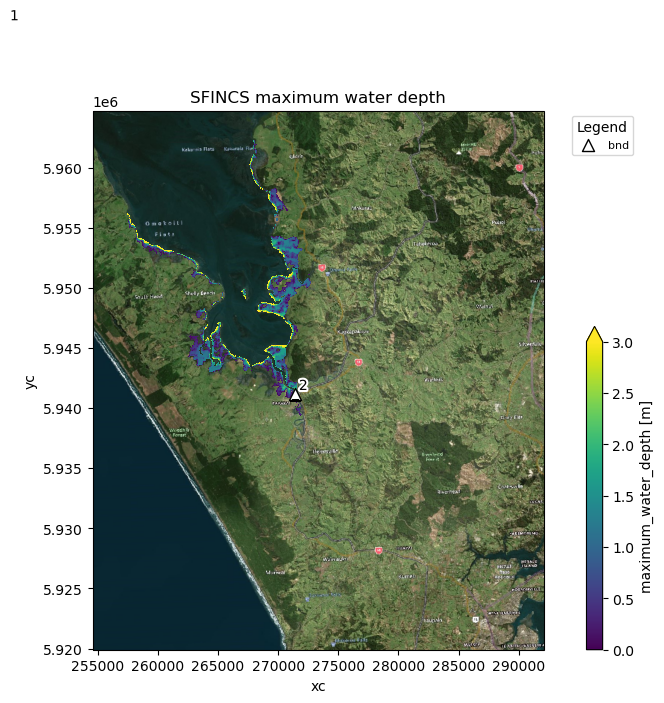

In [18]:
# create hmax plot and save to mod.root/figs/hmax.png
fig, ax = mod.plot_basemap(
    fn_out=None,
    variable="", # no variable to plot, only basemap
    plot_bounds=False,
    bmap="sat",
    zoomlevel=12,
    figsize=(11, 7),
)
# plot overland flooding based on gswo mask and minimum flood depth
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = da_hmax_fld.plot(
    x="xc", y="yc",
    ax=ax,
    vmin=0, vmax=3.0,
    cmap=plt.cm.viridis,
    cbar_kwargs=cbar_kwargs
)

ax.set_title(f"SFINCS maximum water depth")
# plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")